# Generate Immobile/Mobile

- Labels trajectories as immobile/mobile given an sRg cutoff
- Remove mobile trajectories with TAMSD values below localization error estimate
- Generates a data frame with the resulting trajectories including sRg value, mobile/immobile class label and a "treatment" label
- Generates a data set of mobile TAMSD values (trajectories columnwise) without static noise correction for each treatment

what counts as a "treatment"? (cf. Ly et al.)

In [12]:
#requires trajAnalysis to check TAMSD power-law modeling parameters
source('../compute_features/trajAnalysis.R')
options(jupyter.plot_scale=1)

## Input parameters (see Ly et al. for details)
- The sRg cutoff is the 95-percentile of the sRg distribution in the fixed cell "small alpha" population
- The localization error estimate is the most likely value of the power-law coefficient parameter in the fixed cell "small alpha" population
- A vector of "treatment" labels
- Vectors with sRg and TAMSD file names (both same length as treatment labels vector)
- Total number of lags to be used in the TAMSD vs. lag power-law fit  

In [13]:
cutoff<-2.22236433588659
noise<-0.33

In [14]:
#treatment labels
myTreatments<-c('untreated','mbcd')

In [15]:
#Trajectories sRg and TAMSD file names (one per treatement)
sRgfiles<-c('../examples/untreated/untreated-sRg-200.rds','../examples/mbcd/mbcd-sRg-200.rds')
TAMSDfiles<-c('../examples/untreated/untreated-20-TAMSD-200.rds','../examples/mbcd/mbcd-20-TAMSD-200.rds')

In [16]:
#use nlags to fit TAMSD vs lag to a power-law
nlags<-10

## Class and treatment assigment

In [17]:
#add 'class' and 'treatment' columns to the sRg data frame
mylist<-vector('list',length(myTreatments))
for(i in seq_along(myTreatments)) {
    df<-readRDS(sRgfiles[i])
    df$class<-ifelse(df$sRg>cutoff,"mobile","immobile")
    df$treatment<-myTreatments[i]
    mylist[[i]]<-df
    }
    superDF<-do.call(rbind,mylist)

## Mobile trajectories clean-up
- remove trajectories with TAMSD values below static noise
- remove trajectories with power-law exponents greater than 2
- save mobile trajectories TAMSD for additional analyses
- generate power-law exponent statistics as a check

In [18]:
#from the TAMSD list, generate a matrix of TAMSD values for the "mobile" trajectories
#(trajectories columnwise)
myMSD<-vector('list',length(myTreatments))
for(i in seq_along(myTreatments)) {
    msdm<-do.call(cbind,readRDS(TAMSDfiles[i]))
    #mobile trajectory names
    rns<-row.names(superDF[superDF$class=='mobile' 
                           & superDF$treatment==myTreatments[i],])
    myMSD[[i]]<-msdm[,rns]
                 }
names(myMSD)<-myTreatments

untreated 
number and proportion of trajectories excluded: 548 0.2266336 
power-law exponent statistics
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02345 0.52911 0.72493 0.76937 0.98598 1.92880 
     95%      99%    99.9%   99.99% 
1.341958 1.755913 1.920056 1.928773 
mbcd 
number and proportion of trajectories excluded: 613 0.2071646 
power-law exponent statistics
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1133  0.5636  0.7288  0.7646  0.9334  1.9548 
     95%      99%    99.9%   99.99% 
1.242265 1.669262 1.916661 1.951889 


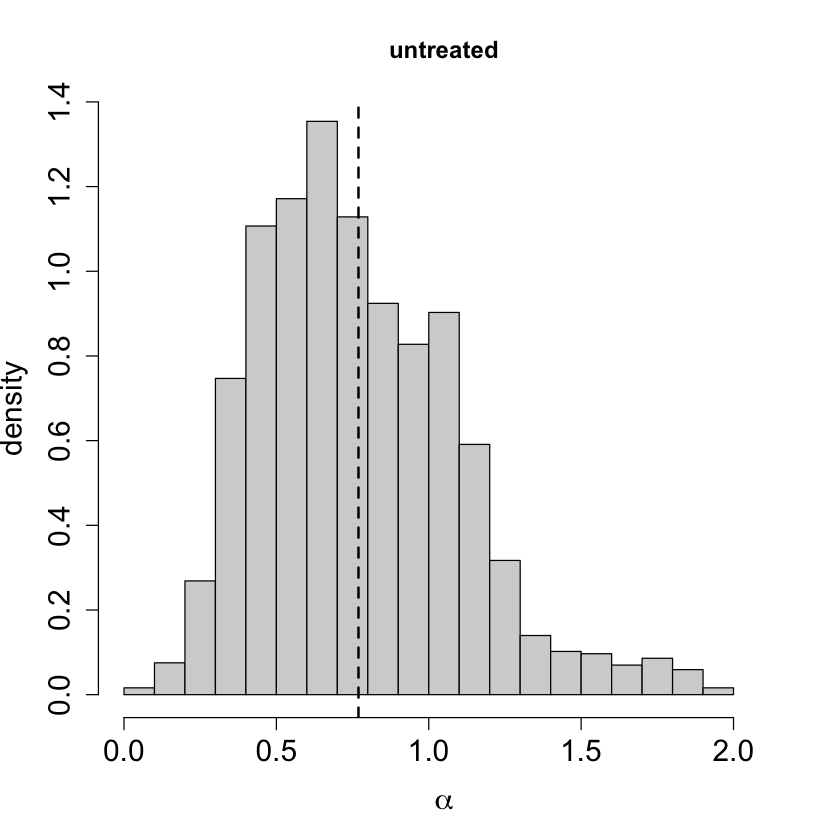

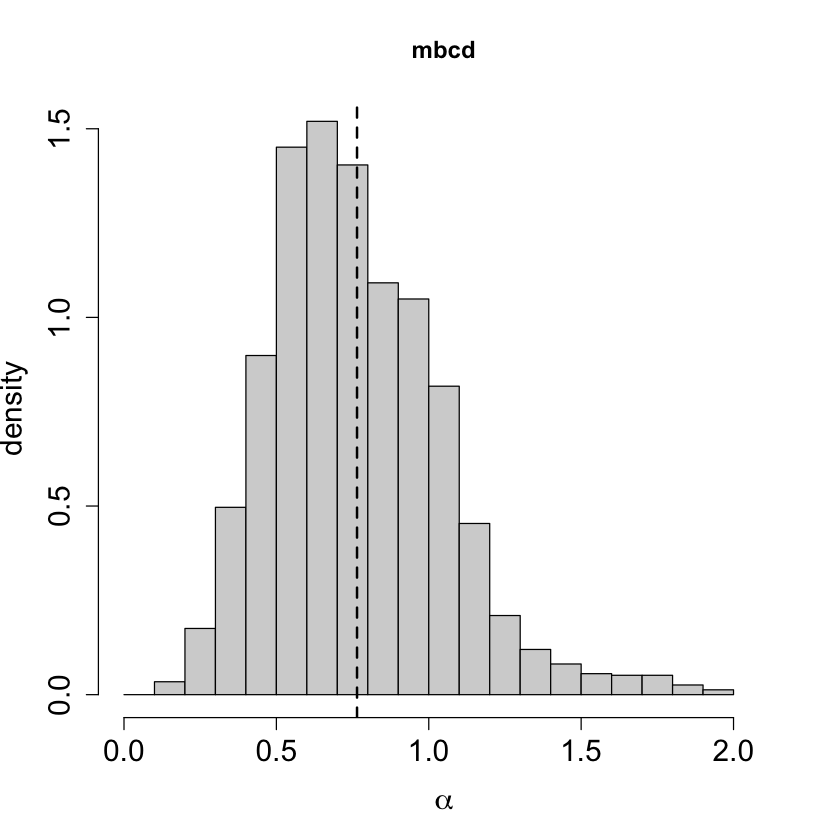

In [19]:
for(i in seq_along(myTreatments)) {
    currMSD<-myMSD[[i]]-noise
    #remove trajectories with negative MSDs beyond permisible lags
    if(any(currMSD<0)){
        baddies<-unique(which((currMSD<0),arr.ind = T)[,2])
        currMSD<-currMSD[,-baddies]
    }
     cat(myTreatments[i],'\n')
    cat('number and proportion of trajectories excluded:',length(baddies),length(baddies)/ncol(myMSD[[i]]),'\n')
    
    #power-law fit
    clags<-seq(1,nlags)
    aDs<-t(apply(currMSD[seq_along(clags),],2,getAlphaD,lags=clags))
    #select entries with power-law exponent <= 2
    goodones<-names(which(aDs[,2]<=2))
    #select entries with a row name
    goodones<-goodones[which(sapply(goodones,nchar)>0)]

    #some checks:
    #power-law exponent statistics
    cat('power-law exponent statistics\n')
    print(summary(aDs[goodones,2]))
    print(quantile(aDs[goodones,2],probs = c(.95,.99,.999,.9999)))
    
    #power-law histogram 
    hist(aDs[goodones,2],breaks=seq(0,2,.1),
     xlim=c(0,2.1),probability = T,xlab = expression(alpha),main=myTreatments[i],ylab='density',cex.lab=1.5,cex.axis=1.5)
    abline(v=mean(aDs[goodones,2]),lty=2,lwd=2)

    myMSD[[i]]<-currMSD[,goodones]
    
    #save mobile trajectories without noise correction
    saveRDS(myMSD[[i]],
            paste0(myTreatments[i],'-mobile-TAMSD-uncorrected.rds'))
    }

## Generate clean sRg/class data frame and save

In [20]:
mobileNames<-unlist(lapply(myMSD,colnames))

In [21]:
#fileter  data frame
superDFsel<-rbind(superDF[mobileNames,],superDF[superDF$class=="immobile",])

In [22]:
saveRDS(superDFsel,'mbcd-untreated-exampleDF.rds')